### Human in the Loop

This is very import for multiple processes such as:
- Approvals 
- Editing 
- Debugging 

Lets see the implementation

In [1]:
from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, AnyMessage
from langchain_core.tools import tool

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Send
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import InMemorySaver

from typing import Annotated, TypedDict, Literal
from pydantic import BaseModel, Field
from dotenv import load_dotenv
import operator
import requests
import os

load_dotenv()

/Users/srinivas/Documents/Others/My_projects/Python/DSAIML/agenticai/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
model = init_chat_model(
    model="qwen/qwen3-32b",  # or any other Groq model
    model_provider="groq",
    temperature=0.7,
)

In [3]:
model.invoke("Hello")

AIMessage(content='<think>\nOkay, the user said "Hello". I need to respond appropriately. Since it\'s a greeting, I should start by greeting them back. Maybe add an emoji to keep it friendly. Then offer assistance. Let them know I\'m here to help with any questions or tasks. Keep the tone welcoming and open-ended. Don\'t make it too formal. Let me put that together.\n</think>\n\nHello! 😊 How can I assist you today? Whether you have questions, need help with a task, or just want to chat, I\'m here for you!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 115, 'prompt_tokens': 9, 'total_tokens': 124, 'completion_time': 0.223793852, 'completion_tokens_details': None, 'prompt_time': 0.000299169, 'prompt_tokens_details': None, 'queue_time': 0.072533351, 'total_time': 0.224093021}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_efa9879028', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--

In [4]:
# Lets create some custom tools

@tool
def get_weather_tool(city: str):
    """
    Given a city name, this function will provide weather information about the city.
    Uses Weatherstack API to fetch the weather.
    """
    url = f'https://api.weatherstack.com/current?access_key={os.getenv("WEATHER_API_KEY")}&query={city}'

    response = requests.get(url)

    return response.json()

@tool
def add_tool(a: int, b: int) -> int:
    """Add two numbers given two inputs."""
    return a + b

@tool
def subtract_tool(a: int, b: int) -> int:
    """Subtract two numbers given two inputs."""
    return a - b

@tool
def multiply_tool(a: int, b: int) -> int:
    """Multiply two numbers given two inputs."""
    return a * b

@tool
def divide_tool(a: int, b: int) -> int:
    """Divide two numbers given two inputs."""
    if b == 0:
        raise ValueError("Cannot divide by zero")
    return a / b

In [5]:
# lets create a tool list 

tools = [
    get_weather_tool,
    add_tool,
    subtract_tool,
    multiply_tool,
    divide_tool,
]

# now bind the model with tools

model_with_tools = model.bind_tools(tools=tools)

In [6]:
# create a chat state
class ChatState(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]

In [19]:
def chat_node(state: ChatState) -> ChatState:
    system_message = SystemMessage(content="You are a helpful assistant. Respond in a friendly and conversational manner. Use the tools below to answer the user's questions whenever possible.")
    messages = [system_message] + state.messages
    response = model_with_tools.invoke(messages)
    return {"messages": state.messages + [response]}

tool_node = ToolNode(tools)

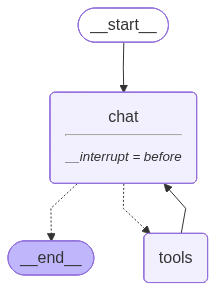

In [20]:
# Build the graph
graph = StateGraph(ChatState)

# add nodes
graph.add_node("chat", chat_node)
graph.add_node("tools", tool_node)

# add edges
graph.add_edge(START, "chat")
graph.add_conditional_edges("chat", tools_condition)
graph.add_edge("tools", "chat")
graph.add_edge("chat", END)

# add memory
memory = InMemorySaver()

# compile the graph

# to add human in the loop  (human feedback)
workflow = graph.compile(interrupt_before=["chat"],checkpointer=memory)
workflow

In [21]:
config = {"configurable": {"thread_id": "chat_2"}}
initial_state = {"messages": [HumanMessage(content="Hello, I'm Srini, What is the weather today in Dallas?")]}

response = workflow.stream(initial_state, config=config, stream_mode="values")
for event in response:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hello, I'm Srini, What is the weather today in Dallas?


In [22]:
state = workflow.get_state(config=config)
print(state)
print(state.next)

StateSnapshot(values={'messages': [HumanMessage(content="Hello, I'm Srini, What is the weather today in Dallas?", additional_kwargs={}, response_metadata={}, id='157c9d7e-8825-4c86-a34f-ede210ca5103')]}, next=('chat',), config={'configurable': {'thread_id': 'chat_2', 'checkpoint_ns': '', 'checkpoint_id': '1f0ce201-86f8-636e-8000-ac30adb76f48'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-11-30T19:09:29.272192+00:00', parent_config={'configurable': {'thread_id': 'chat_2', 'checkpoint_ns': '', 'checkpoint_id': '1f0ce201-86f5-6cf4-bfff-efc1f17d7554'}}, tasks=(PregelTask(id='ba048dac-a341-6d70-fee9-d7f4fef51da3', name='chat', path=('__pregel_pull', 'chat'), error=None, interrupts=(), state=None, result=None),), interrupts=())
('chat',)


In [23]:
#  To continue with the next state (pass None as the initial state, as it is confirmation)
response = workflow.stream(None, config=config, stream_mode="values")
for event in response:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hello, I'm Srini, What is the weather today in Dallas?
================================== Ai Message ==================================
Tool Calls:
  get_weather_tool (0ysdgqw6g)
 Call ID: 0ysdgqw6g
  Args:
    city: Dallas
================================= Tool Message =================================
Name: get_weather_tool

{"request": {"type": "City", "query": "Dallas, United States of America", "language": "en", "unit": "m"}, "location": {"name": "Dallas", "country": "United States of America", "region": "Texas", "lat": "32.783", "lon": "-96.800", "timezone_id": "America/Chicago", "localtime": "2025-11-30 13:04", "localtime_epoch": 1764507840, "utc_offset": "-6.0"}, "current": {"observation_time": "07:04 PM", "temperature": 4, "weather_code": 122, "weather_icons": ["https://cdn.worldweatheronline.com/images/wsymbols01_png_64/wsymbol_0004_black_low_cloud.png"], "weather_descriptions": ["Overcast"], "a

In [24]:
state = workflow.get_state(config=config)
print(state)
print(state.next)

StateSnapshot(values={'messages': [HumanMessage(content="Hello, I'm Srini, What is the weather today in Dallas?", additional_kwargs={}, response_metadata={}, id='157c9d7e-8825-4c86-a34f-ede210ca5103'), AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, Srini asked about the weather in Dallas. Let me check which tool to use. The available functions include get_weather_tool, which requires a city name. Since the user mentioned Dallas, I should call that function with "Dallas" as the city parameter. The other tools are for math operations, which don\'t apply here. So I\'ll generate the tool call for get_weather_tool with city set to Dallas.\n', 'tool_calls': [{'id': '0ysdgqw6g', 'function': {'arguments': '{"city":"Dallas"}', 'name': 'get_weather_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 109, 'prompt_tokens': 482, 'total_tokens': 591, 'completion_time': 0.191323304, 'completion_tokens_details': {'reasoning_tokens': 84}, 'prompt

In [25]:
#  To continue with the next state (pass None as the initial state, as it is confirmation)
response = workflow.stream(None, config=config, stream_mode="values")
for event in response:
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: get_weather_tool

{"request": {"type": "City", "query": "Dallas, United States of America", "language": "en", "unit": "m"}, "location": {"name": "Dallas", "country": "United States of America", "region": "Texas", "lat": "32.783", "lon": "-96.800", "timezone_id": "America/Chicago", "localtime": "2025-11-30 13:04", "localtime_epoch": 1764507840, "utc_offset": "-6.0"}, "current": {"observation_time": "07:04 PM", "temperature": 4, "weather_code": 122, "weather_icons": ["https://cdn.worldweatheronline.com/images/wsymbols01_png_64/wsymbol_0004_black_low_cloud.png"], "weather_descriptions": ["Overcast"], "astro": {"sunrise": "07:11 AM", "sunset": "05:21 PM", "moonrise": "02:09 PM", "moonset": "02:09 AM", "moon_phase": "Waxing Gibbous", "moon_illumination": 68}, "air_quality": {"co": "272.85", "no2": "33.55", "o3": "29", "so2": "4.25", "pm2_5": "5.95", "pm10": "5.95", "us-epa-index": "1", "gb-defra-index": "

### Add Human Feedback

In [26]:
config = {"configurable": {"thread_id": "chat_3"}}
initial_state = {"messages": [HumanMessage(content="Hello, I'm Srini, Multiply 2 with 8?")]}

response = workflow.stream(initial_state, config=config, stream_mode="values")
for event in response:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hello, I'm Srini, Multiply 2 with 8?


In [27]:
# now it has intrupted

state = workflow.get_state(config=config)
print(state)
print(state.next)

StateSnapshot(values={'messages': [HumanMessage(content="Hello, I'm Srini, Multiply 2 with 8?", additional_kwargs={}, response_metadata={}, id='bab16108-ca87-4bd9-94be-2a5dfc990325')]}, next=('chat',), config={'configurable': {'thread_id': 'chat_3', 'checkpoint_ns': '', 'checkpoint_id': '1f0ce3a5-a4c5-6d24-8000-3943fb7653c8'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-11-30T22:17:26.686431+00:00', parent_config={'configurable': {'thread_id': 'chat_3', 'checkpoint_ns': '', 'checkpoint_id': '1f0ce3a5-a4c3-629a-bfff-72298c62f246'}}, tasks=(PregelTask(id='35ae9595-1c8b-89a2-3585-7f64d01e25a7', name='chat', path=('__pregel_pull', 'chat'), error=None, interrupts=(), state=None, result=None),), interrupts=())
('chat',)


In [28]:
workflow.update_state(config, {"messages": [HumanMessage(content="No, please Multiply 2 with 20")]})


{'configurable': {'thread_id': 'chat_3',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ce3ad-ed32-6686-8001-2eb07fef5101'}}

In [29]:
updated_state = workflow.get_state(config=config).values

for message in updated_state["messages"]:
    message.pretty_print()
    

================================ Human Message =================================

Hello, I'm Srini, Multiply 2 with 8?
================================ Human Message =================================

No, please Multiply 2 with 20


In [30]:
response = workflow.stream(None, config=config, stream_mode="values")
for event in response:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

No, please Multiply 2 with 20
================================== Ai Message ==================================
Tool Calls:
  multiply_tool (x780z18nn)
 Call ID: x780z18nn
  Args:
    a: 2
    b: 20
================================= Tool Message =================================
Name: multiply_tool

40


In [31]:
# Now after the update and workflow execution it has interrupted again as it went back to chat node

# lets run it
response = workflow.stream(None, config=config, stream_mode="values")
for event in response:
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply_tool

40
================================== Ai Message ==================================

The result of multiplying 2 with 20 is **40**! Let me know if you need anything else. 😊


Here we were able to update the state, then continue with the workflow (Manually)